In [ ]:
import idx2numpy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [ ]:
train_images_path = '../../../Documents/data/MNIST_ORG//train-images.idx3-ubyte'
train_labels_path = '../../../Documents/data/MNIST_ORG//train-labels.idx1-ubyte'
test_images_path = '../../../Documents/data/MNIST_ORG//t10k-images.idx3-ubyte'
test_labels_path = '../../../Documents/data/MNIST_ORG//t10k-labels.idx1-ubyte'

In [ ]:
#laod data
X_train = idx2numpy.convert_from_file(train_images_path)
y_train = idx2numpy.convert_from_file(train_labels_path)
X_test = idx2numpy.convert_from_file(test_images_path)
y_test = idx2numpy.convert_from_file(test_labels_path)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

lets look at what one looks like

In [ ]:
indices = [5000, 2001, 2002, 2003, 2004, 2005]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title(f'True Label: {y_train[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

lets lokat the distuion of each class

In [ ]:
plt.hist(y_train, bins=np.arange(11)-.5, edgecolor='black');
plt.xticks([i for i in range(10)]);

In [ ]:
unique, counts =np.unique(y_train, return_counts=True)
count_dic = dict(zip(unique, counts))


print(f'The max class is {max(count_dic, key=count_dic.get)} and min class is {min(count_dic, key=count_dic.get)}.')
print(f'Class {max(count_dic, key=count_dic.get)} has {(max(count_dic.values())-min(count_dic.values()))/min(count_dic.values())*100:.1f}% more values than class {min(count_dic, key=count_dic.get)}')

so our dataset is pretty balnced and we will go ahed and start some mlp

In [ ]:
X_train.shape

In [ ]:
X_train = torch.Tensor(X_train).flatten(start_dim=1 , end_dim=2)
y_train = torch.Tensor(y_train).long()
#they are no one hot encoded but rather [4,6,8,......]
y_train = nn.functional.one_hot(y_train,num_classes=10).float()

X_test = torch.Tensor(X_test).flatten(start_dim=1 , end_dim=2)
y_test = torch.Tensor(y_test).long()
y_test = nn.functional.one_hot(y_test,num_classes=10).float()

In [ ]:
X_train.shape

In [ ]:
y_train.argmax(dim=1).unique(return_counts=True)

lets do and mlp first and see how it does

In [ ]:
class IRONMAN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(IRONMAN, self).__init__()
        self.l0 = nn.Linear(784, 256)
        self.relu0 = nn.ReLU()
        self.dropout0 = nn.Dropout(dropout_rate)
        
        self.l1 = nn.Linear(256, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.l2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.l3 = nn.Linear(32, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.l4 = nn.Linear(32, 10)
        self.out = nn.Sigmoid()

    def forward(self, X):
        x = self.dropout0(self.relu0(self.l0(X)))
        x = self.dropout1(self.relu1(self.l1(x)))
        x = self.dropout2(self.relu2(self.l2(x)))
        logits = self.l4(x)
        x = self.out(logits)
        return x, logits


ironman = IRONMAN()
optimizer = torch.optim.AdamW(params=ironman.parameters(), lr=0.0003, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
lossi = []
devlossi = []

train_dataset = TensorDataset(X_train, y_train)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(50)):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        out, logits = ironman.forward(X_batch)
        
        optimizer.zero_grad()
        loss = criterion(logits, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    lossi.append(epoch_loss / len(train_loader))  # append avg loss per epoch

    with torch.no_grad():
        devout, devlogits = ironman.forward(X_test)
        devloss  = criterion(devlogits, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2 == 0:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")

In [ ]:
with torch.no_grad():
    y_pred, logits = ironman.forward(X_test)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true');

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred');


print(classification_report(y_true=y_true, y_pred=y_pred));

Now lets do a nn with convolution

In [437]:
X_train = X_train.view(-1,28,28).unsqueeze(1)

X_test = X_test.view(-1,28,28).unsqueeze(1)
X_test.shape

torch.Size([10000, 1, 28, 28])

In [442]:
class CORKSCREW(nn.Module):
    def __init__(self):
        super(CORKSCREW, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc0 = nn.Linear(64 * 7 * 7, 10)

        self.relu = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x))) 
        
        x = x.view(-1, 64 * 7 * 7)  #flatten
        
        logits = self.relu(self.fc0(x))
        x = self.out(logits)
        
        return x, logits

corkscrew = CORKSCREW()
optimizer = torch.optim.AdamW(params=corkscrew.parameters(), lr=0.0003, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [433]:
xi, yi = next(iter(train_loader))

In [435]:
xi.unsqueeze(1).shape

torch.Size([32, 1, 28, 28])

In [436]:
X_train.shape

torch.Size([60000, 28, 28])

 12%|█▏        | 6/50 [02:33<18:42, 25.52s/it]


KeyboardInterrupt: 

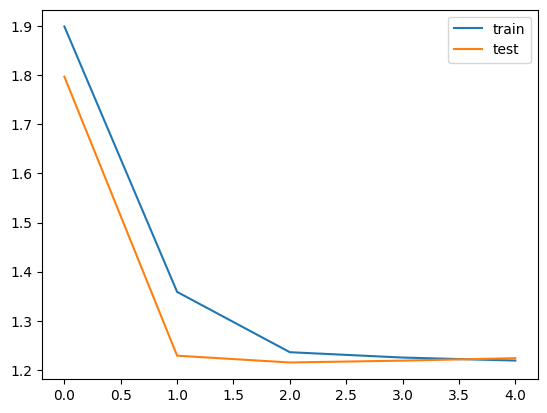

In [444]:
lossi = []
devlossi = []

train_dataset = TensorDataset(X_train, y_train)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


for epoch in tqdm(range(50)):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        out, logits = corkscrew.forward(X_batch)
        
        optimizer.zero_grad()
        loss = criterion(logits, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    lossi.append(epoch_loss / len(train_loader))  # append avg loss per epoch

    with torch.no_grad():
        devout, devlogits = corkscrew.forward(X_test)
        devloss  = criterion(devlogits, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2 == 0:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")

              precision    recall  f1-score   support

           0       0.16      1.00      0.28       980
           1       0.00      0.00      0.00      1135
           2       0.97      0.99      0.98      1032
           3       0.00      0.00      0.00      1010
           4       0.97      0.99      0.98       982
           5       0.93      0.99      0.96       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.48     10000
   macro avg       0.40      0.49      0.42     10000
weighted avg       0.39      0.48      0.41     10000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

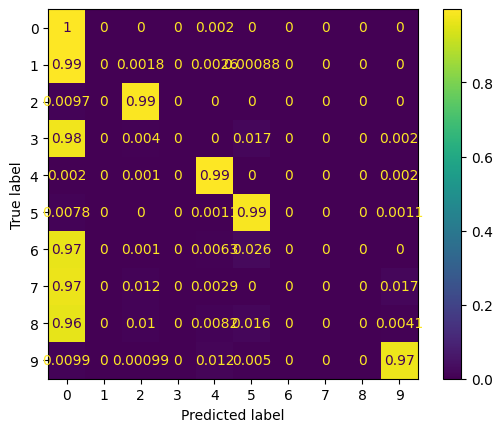

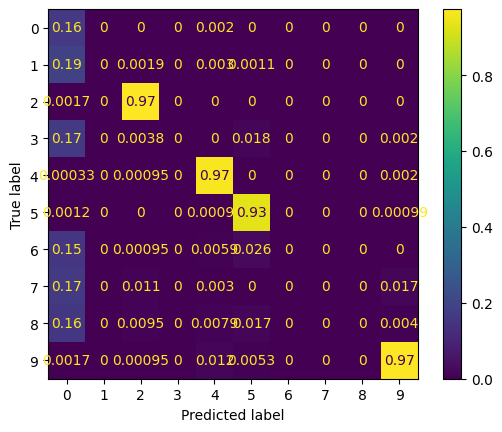

In [446]:
with torch.no_grad():
    y_pred, logits = corkscrew.forward(X_test)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true');

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred');


print(classification_report(y_true=y_true, y_pred=y_pred));